## 2 - Plate Reconstructions

In this notebook, we will set up and use a plate reconstruction model with GPlately's `PlateReconstruction` object.

The `PlateReconstruction` object contains methods to reconstruct topology features to a specific geological time. All you need to do to use this object is provide a rotation model, topology features (or feature collection) and a set of static polygons. 

In [1]:
import gplately

import numpy as np
import gplately.pygplates as pygplates
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.gridliner as grd

from matplotlib.patches import Patch
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D

We use gplately to generate a plate reconstruction model using data from "A Global Plate Model Including Lithospheric Deformation Along Major Rifts and Orogens Since the Triassic" by Müller et al. (2019). (Source: https://www.earthbyte.org/muller-et-al-2019-deforming-plate-reconstruction-and-seafloor-age-grids-tectonics/). 

To generate this model, we will need three types of files:
1. A set of rotation files - files that end in ".rot"
2. A set of topology feature files - typically of type ".gpml" or ".gpmlz"
2. A set of static polygons

... and these need to be turned to certain pygplates objects using the [`gplately.pygplates`](https://gplates.github.io/gplately/pygplates.html) module:

- Rotation files must be passed to a `<pygplates.RotationModel>` object,
- Topology features must be passed to a `<pygplates.FeatureCollection>` object
- Static polygons must be passed to a `<pygplates.FeatureCollection>` object

We demonstrate **two ways** to load plate model files:

### Method 1: Loading local files
The cell below shows how the `glob` and `os` libraries locate rotation files, topology feature files, and static polygon files from a directory(s) on your computer. We then use these file path strings to generate the necessary gplately.pygplates `<gplately.pygplates.RotationModel>`, `<gplately.pygplates.FeatureCollection>` and `<gplately.pygplates.FeatureCollection>` objects.

In [2]:
# To use Method 1, make True. Otherwise, keep as False
use_local_files = False

In [3]:
if use_local_files:

    # Directory to plate model files
    input_directory = "./NotebookFiles/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/"

    # Locate rotation files and set up the RotationModel object
    rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
    rotation_model = RotationModel(rotation_filenames)

    # Locate topology feature files and set up a FeatureCollection object 
    topology_filenames = glob.glob(os.path.join(input_directory, '*.gpml'))
    topology_features = pygplates.FeatureCollection()
    for topology_filename in topology_filenames:
        # (omit files with the string "inactive" in the filepath)
        if "Inactive" not in topology_filename:
            topology_features.add( pygplates.FeatureCollection(topology_filename) )
        else:
            topology_filenames.remove(topology_filename)

    # Locate static polygons and set up another FeatureCollection object
    static_polygon_file = input_directory+"StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2019_v1.shp"
    static_polygons = pygplates.FeatureCollection(static_polygon_file)


### Method 2: Loading files with gplately's `DataServer`

You can also use gplately's `DataServer` object to download necessary plate reconstruction files from [supported plate models](https://gplates.github.io/gplately/download.html#gplately.download.DataServer). `DataServer` stores these files in your system cache. 

To select a supported plate model, pass an ID string to the object, e.g. `"Muller2019"` for the Müller et al. (2019) model.

We can get the three types of files using `DataServer`'s function `get_plate_reconstruction_files()` as shown below. The function returns the following:
- Rotation files are returned as a `<pygplates.RotationModel>` object,
- Topology features are returned as a `<pygplates.FeatureCollection>` object
- Static polygons are returned as a `<pygplates.FeatureCollection>` object

In [4]:
if not use_local_files:
    # Call GPlately's DataServer from the download.py module
    gdownload = gplately.download.DataServer("Muller2019")

    # Obtain all rotation files, topology features and static polygons from Muller et al. 2019
    rotation_model, topology_features, static_polygons = gdownload.get_plate_reconstruction_files()

Checking whether the requested files need to be updated...
Requested files are up-to-date!


### Constructing a plate motion model using the `PlateReconstruction` object

Once we have our rotation model, topology features and static polygons, we can supply them to the `PlateReconstruction` object to construct the plate motion model.

In [5]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

### Reconstructing feature geometries

The plate motion model we created can be used to generate plate reconstructions through geological time. Let's reconstruct subduction zones and mid-ocean ridges to 50 Ma.

In [6]:
time = 50 #Ma
subduction_data = model.tesselate_subduction_zones(time, ignore_warnings=True)
ridge_data = model.tesselate_mid_ocean_ridges(time, ignore_warnings=True)

### Plotting plate reconstructions with the `PlotTopologies` object. 

Let's visualise this reconstruction on a GeoAxis plot using gplately's `PlotTopologies` object. To call the object, we need to supply:

- the `PlateReconstruction` plate motion model we just created
- a specific reconstruction time (Ma),
- a coastline filename or `<pygplates.FeatureCollection>` object,
- a continent filename or `<pygplates.FeatureCollection>` object,
- and a continent-ocean boundary (COBs) filename or `<pygplates.FeatureCollection>` object,

We demonstrate the same methods used above to locate coastline, continent and COB files.

### Method 1: Loading local files
We re-use the same `input_directory` defined to fetch local plate reconstruction files to now load coastlines, continents and COBs:

In [7]:
if use_local_files:
    coastlines = input_directory+"StaticGeometries/Coastlines/Global_coastlines_2019_v1_low_res.shp"
    continents = input_directory+"StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2019_v1.shp"
    COBs = input_directory+"StaticGeometries/AgeGridInput/Global_EarthByte_GeeK07_IsoCOB_2019_v2.gpml"

### Method 2: Loading files with `DataServer` 

We already defined a `DataServer` object above (we called it `gdownload`) to get a rotation model, topology features and static polygons. Let's re-use this object to locate coastlines, continents and COBs downloaded to the system cache.

In [8]:
if not use_local_files:
    # Obtain geometry shapefiles with gdownload
    coastlines, continents, COBs = gdownload.get_topology_geometries()

Checking whether the requested files need to be updated...
Requested files are up-to-date!


### Define the `PlotTopologies` object
Let's call the `PlotTopologies` object 'gplot' and set it up to visualise geologic features at 50 Ma:

In [9]:
# Call the PlotTopologies object
time = 50 #Ma
gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

To plot using GPlately's `PlotTopologies` object, first create a GeoAxis plot (here we call it `ax`) and [select a projection using Cartopy](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html). This is the plot we supply to our gplot object.

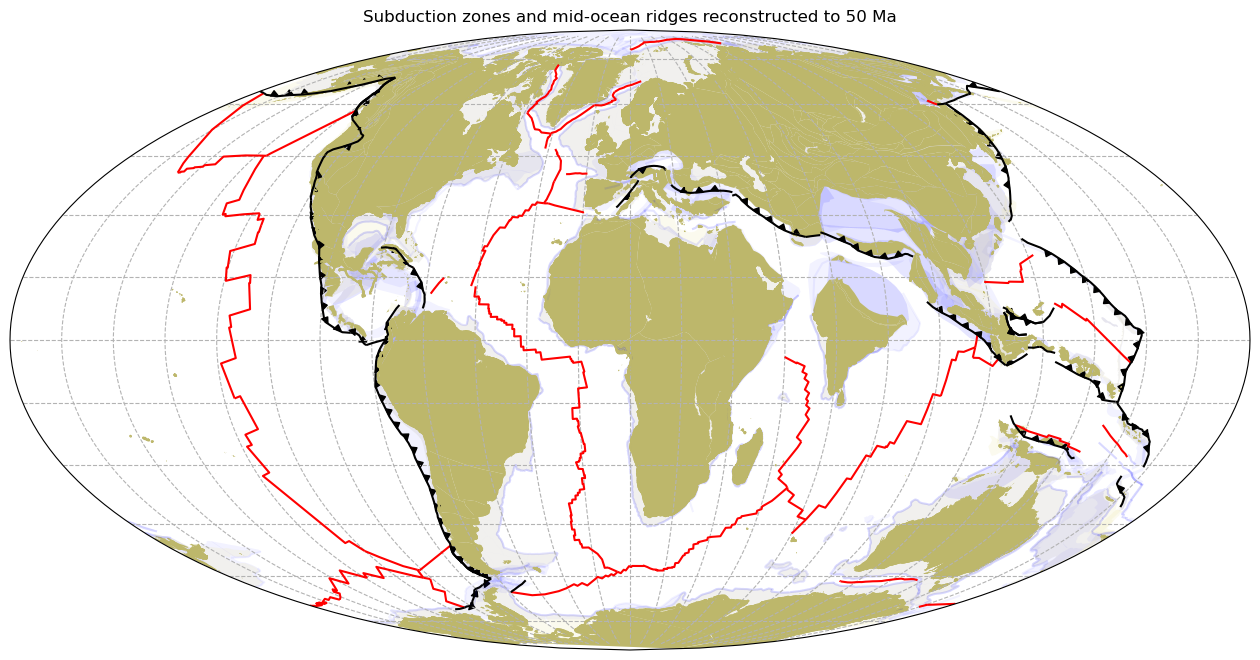

In [10]:
# Set up a GeoAxis plot
fig = plt.figure(figsize=(16,12), dpi=100)
ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
plt.title('Subduction zones and mid-ocean ridges reconstructed to %i Ma' % (time))

# Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
gplot.time = time # Ma
gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
gplot.plot_continents(ax, facecolor='palegoldenrod', alpha=0.2)
gplot.plot_coastlines(ax, color='DarkKhaki')
gplot.plot_ridges_and_transforms(ax, color='red')
gplot.plot_trenches(ax, color='k')
gplot.plot_subduction_teeth(ax, color='k')
ax.set_global()

If you have moviepy available, you can create a gif that illustrates plate motions through geological time. Let's reconstruct plate movements up to 100 Ma in intervals of 10 Ma!

In [11]:
# Time variables
oldest_seed_time = 100 # Ma
time_step = 10 # Ma

# Create a plot for each 10 Ma interval
for time in np.arange(oldest_seed_time,0.,-time_step):
    
    # Set up a GeoAxis plot
    fig = plt.figure(figsize=(18,10), dpi=100)
    ax = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 0))
    ax.gridlines(color='0.7',linestyle='--', xlocs=np.arange(-180,180,15), ylocs=np.arange(-90,90,15))
    plt.title('Subduction zones and mid-ocean ridges reconstructed to %i Ma' % (time))

    # Update the reconstruction time to allocate to PlotTopologies
    gplot.time = time
    
    # Plot shapefile features, subduction zones and MOR boundaries at 50 Ma
    gplot.time = time # Ma
    gplot.plot_continent_ocean_boundaries(ax, color='b', alpha=0.05)
    gplot.plot_continents(ax, facecolor='palegoldenrod', alpha=0.2)
    gplot.plot_coastlines(ax, color='DarkKhaki')
    gplot.plot_ridges_and_transforms(ax, color='red')
    gplot.plot_trenches(ax, color='k')
    gplot.plot_subduction_teeth(ax, color='k')
    ax.set_global()
    plt.savefig('/tmp/subd_mor_boundary_features_%d_Ma.png' % time)
    plt.close()
    
    print('Image for %d Ma saved' % time)

Image for 100 Ma saved
Image for 90 Ma saved
Image for 80 Ma saved
Image for 70 Ma saved
Image for 60 Ma saved
Image for 50 Ma saved
Image for 40 Ma saved
Image for 30 Ma saved
Image for 20 Ma saved
Image for 10 Ma saved


MoviePy - Building file /tmp/subd_mor_boundary_features.gif with imageio.


The movie will show up in a few seconds. Please be patient...


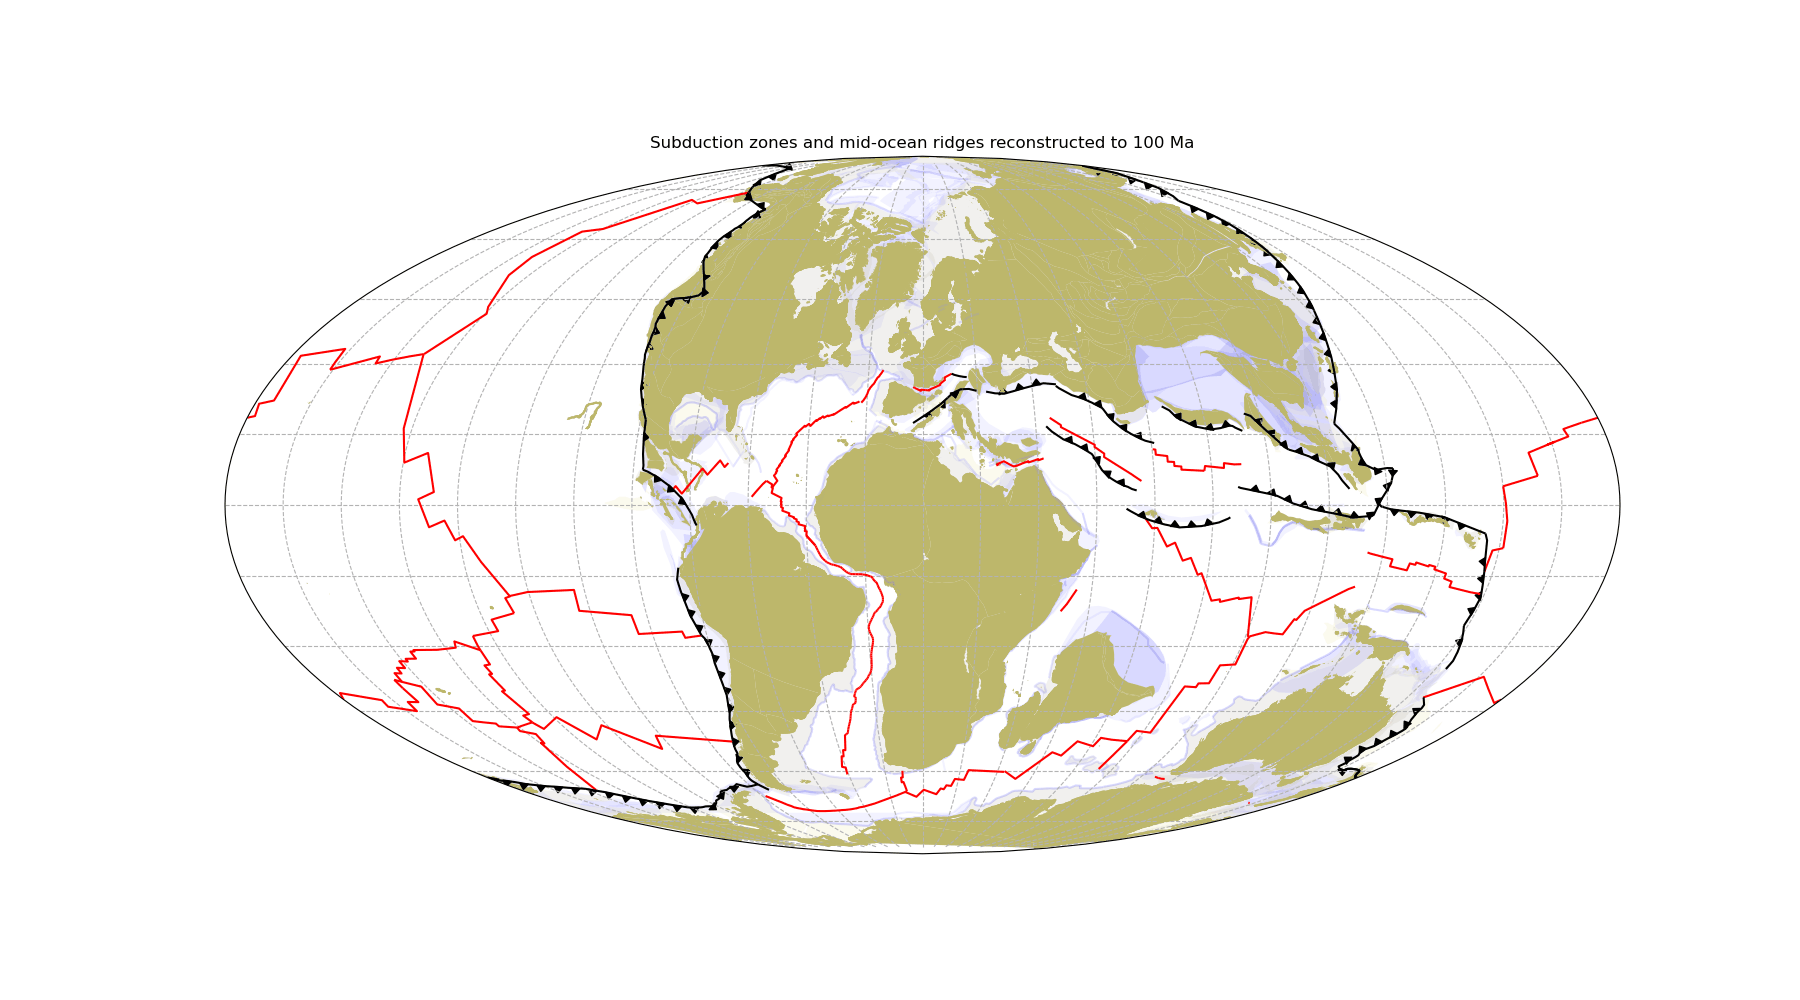

In [12]:
import moviepy.editor as mpy

frame_list = []

for time in np.arange(oldest_seed_time,0.,-time_step):
    frame_list.append('/tmp/subd_mor_boundary_features_%d_Ma.png' % time)
    

clip = mpy.ImageSequenceClip(frame_list, fps=5)
clip.write_gif('/tmp/subd_mor_boundary_features.gif')

from IPython.display import Image
print('The movie will show up in a few seconds. Please be patient...')
with open('/tmp/subd_mor_boundary_features.gif','rb') as f:
    display(Image(data=f.read(), format='png', width = 2000, height = 500))

## Comparing two different plate models
Let's create another `PlateReconstruction` object with another set of `rotation_model`, `topology_features`, and `static_polygons` files from _"Ocean basin evolution and global-scale plate reorganization events since Pangea breakup"_ by Muller et al. (2016). This time, let's pass the string `"Muller2016"` into `DataServer` to get these plate model files.

In [13]:
# Point GPlately's DataServer object to Müller et al. 2016
gdownload2 = gplately.download.DataServer("Muller2016")

# Obtain rotation files, topology features and static polygons from Müller et al. 2016
rotation_model2, topology_features2, static_polygons2 = gdownload2.get_plate_reconstruction_files()

model2 = gplately.PlateReconstruction(rotation_model2, topology_features2)

# Obtain features for the PlotTopologies object
coastlines2, continents2, COBs2 = gdownload2.get_topology_geometries()

# Call the PlotTopologies object
time = 0 #Ma
gplot2 = gplately.plot.PlotTopologies(model2, time, coastlines2, continents2, COBs2)

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!
No continents in Muller2016.
No continent-ocean boundaries in Muller2016.


Let's plot these plate topologies along with those from Müller et al. (2019) which uses near-neighbor interpolation, ultiamtely removing topologies that have had no deformation.

Checking whether the requested files need to be updated...
Requested files are up-to-date!
Checking whether the requested files need to be updated...
Requested files are up-to-date!


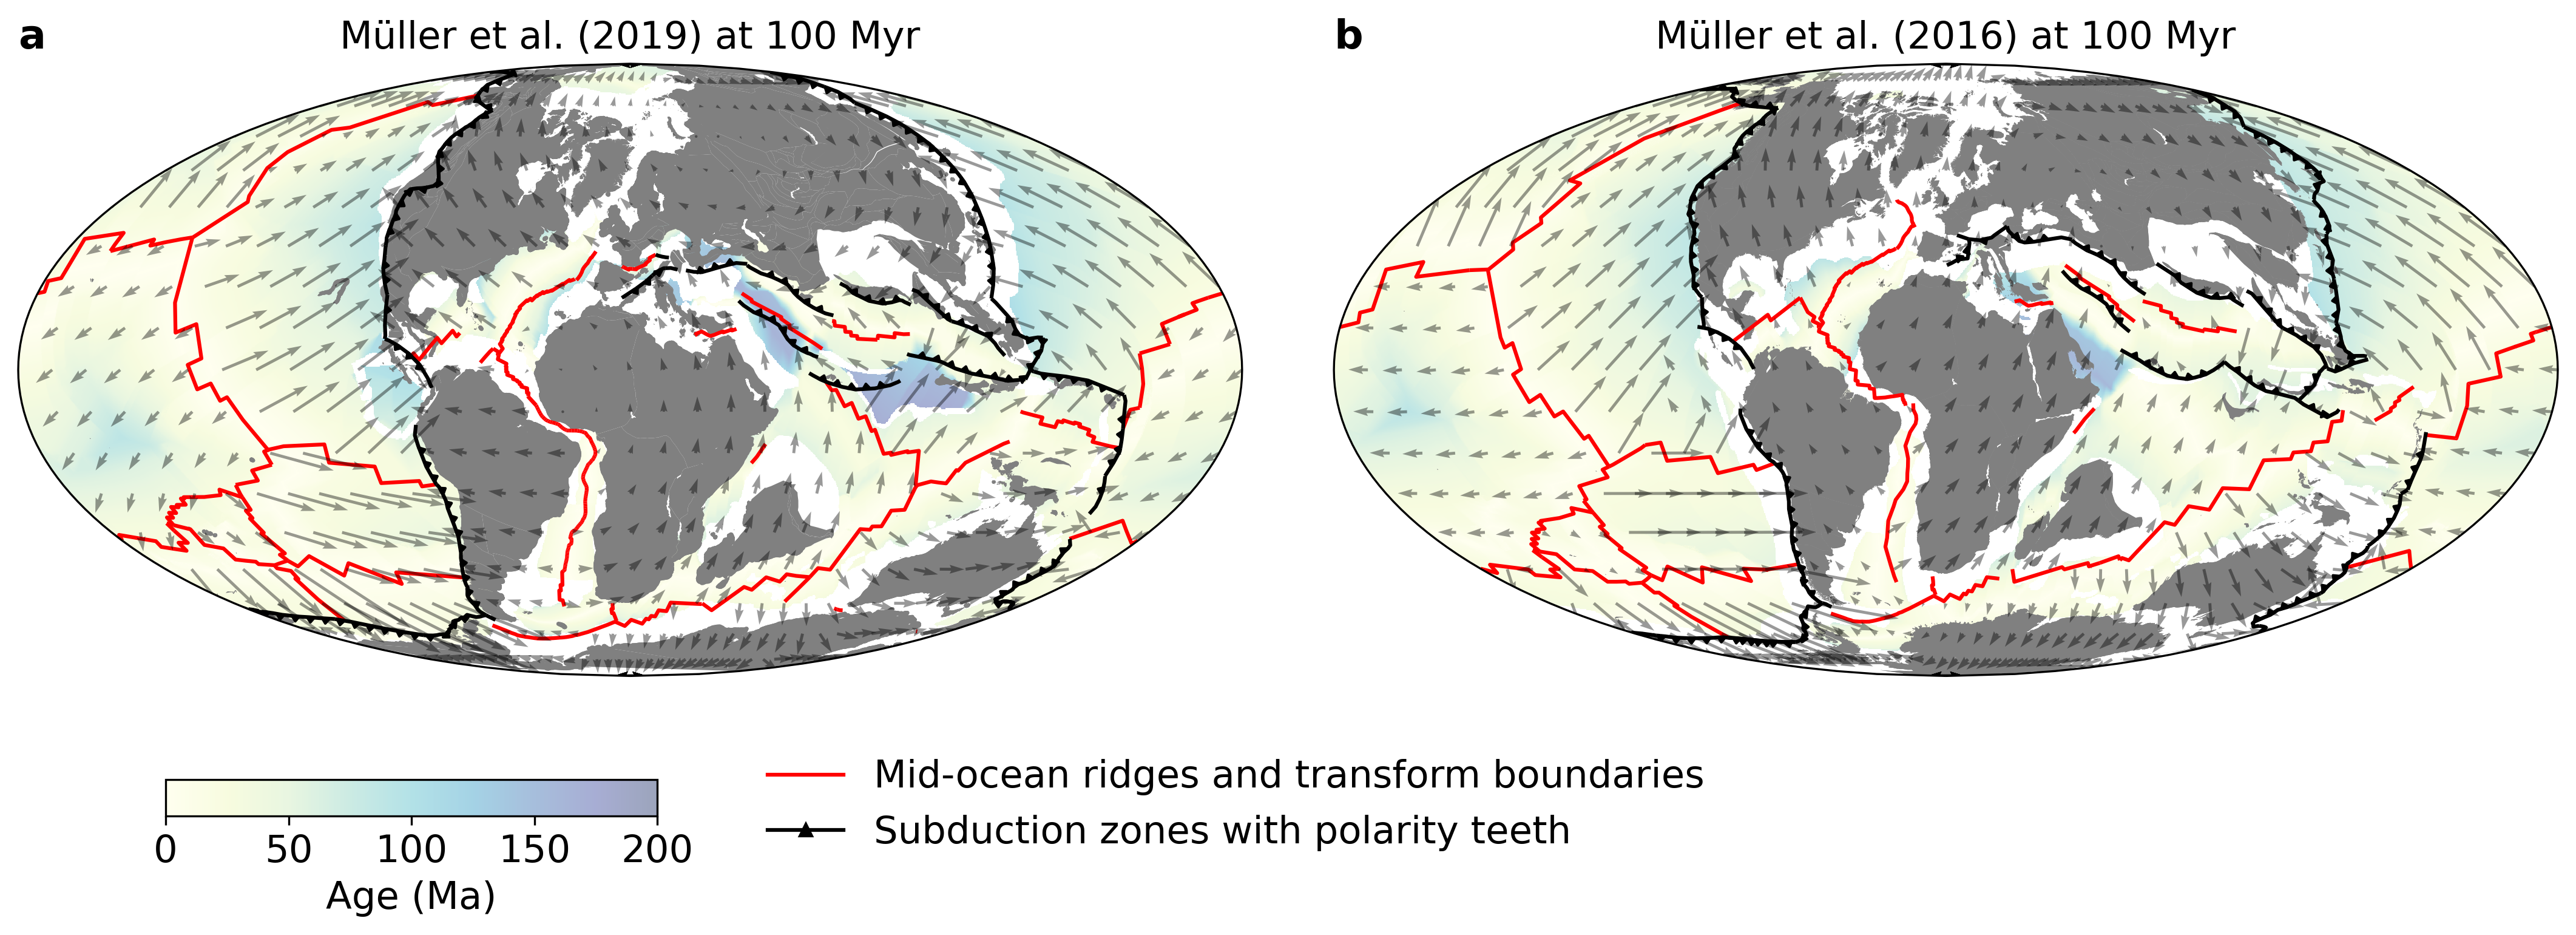

In [14]:
# set reconstruction time
time = 100
gplot.time = time
gplot2.time = time

# Get the Müller et al. (2016) and Müller et al. (2019) age grids at corresponding time.
# These are returned as gplately.Raster objects.
muller2016_nc = gdownload.get_age_grid(time)
muller2019_nc = gdownload2.get_age_grid(time)

# Set up a GeoAxis plot
fig = plt.figure(figsize=(18,10), dpi=300)

# ----------------------------------------------- FIRST SUBPLOT -----------------------------------------------------
ax1 = fig.add_subplot(121, projection=ccrs.Mollweide(central_longitude = 0))
plt.title("Müller et al. (2019) at {} Myr".format(time), fontsize=15)
ax1.set_title("a", loc='left', fontsize="16", weight="demi")
ax1.set_global()

# Plot seafloor age grids, coastlines, subduction zones, MOR and transform boundaries at present day

gplot.plot_coastlines(ax1, color='0.5')
gplot.plot_ridges_and_transforms(ax1, color='r')
im = gplot.plot_grid(ax1, muller2019_nc.data, cmap='YlGnBu', vmin=0, vmax=200, alpha=0.4)
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k', zorder=4)
gplot.plot_plate_motion_vectors(ax1, spacingX=10, spacingY=10, normalise=False, zorder=4, alpha=0.4)



# ----------------------------------------------- SECOND SUBPLOT ----------------------------------------------------
ax2 = fig.add_subplot(122, projection=ccrs.Mollweide(central_longitude = 0))
plt.title("Müller et al. (2016) at {} Myr".format(time), fontsize=15)
ax2.set_title("b", loc='left', fontsize="16", weight="demi")

# Plot seafloor age grids, coastlines, subduction zones, MOR and transform boundaries at present day
gplot2.plot_coastlines(ax2, color='0.5')
gplot2.plot_ridges_and_transforms(ax2, color='r',)
# Use the age grid for the current time step
im = gplot.plot_grid(ax2, muller2016_nc.data, cmap='YlGnBu', vmin=0, vmax=200, alpha=0.4)
gplot2.plot_trenches(ax2, color='k')
gplot2.plot_subduction_teeth(ax2, color='k', label="Subduction polarity teeth")
gplot2.plot_plate_motion_vectors(ax2, spacingX=10, spacingY=10, normalise=False, zorder=10, alpha=0.4)


# ----------------------------------------------- PLOT PROPERTIES -----------------------------------------------------
plt.subplots_adjust(wspace=0.075) # spacing between subplots

# Colorbar settings
cb_ax = fig.add_axes([0.17, 0.25, 0.15, 0.02])
cb = fig.colorbar(im, cax=cb_ax, orientation='horizontal', shrink=0.4, pad=0.05)
cb.set_label(label='Age (Ma)', fontsize=15)
cb.set_ticklabels(ticklabels=np.arange(0,201,50), fontsize=15)

# Legend settings
legend_elements = [Line2D([0], [0], linestyle='-', color='r',
                          label="Mid-ocean ridges and transform boundaries"),
                   Line2D([0], [0], marker='^', linestyle='-', color='k',
                          label='Subduction zones with polarity teeth',
                          markerfacecolor='k', markersize=5),
                   # FancyArrowPatch(0,0,0,0, color='k', alpha=0.4, label="Plate velocity vectors"),
                  ]

lg = fig.legend(handles=legend_elements, bbox_to_anchor=(0.65,0.3), ncol=1, fontsize = 15, frameon=False)